# Developing FEM in 1D

Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as sla

## Boundary Value Problem

$$
\begin{align*}
- u'' &= f(x)\\
u(0) = u(1) &= 0
\end{align*}
$$

In [2]:
if 1:
    def f(x):
        return 2+0*x
    
    def uexact(x):
        return x*(1-x)
    
elif 1:
    wavenr = 5
    
    def uexact(x):
        return np.sin(wavenr * np.pi * x)
    def f(x):
        return (wavenr*np.pi)**2 * uexact(x)
    
else:
    def f(x):
        return 100*np.exp(-(x-0.5)**2 / 0.001)
    
    uexact = None

## Grid Setup

`V` is a list of vertices.  `E` is a list of elements (segments).

In [3]:
# number of points, crank me up
nx = 6

V = np.linspace(0,1,nx)
E = np.zeros((nx-1,2), dtype=int)
E[:,0] = np.arange(0,nx-1)
E[:,1] = np.arange(1,nx)
h = V[1] - V[0] # mesh spacing

In [4]:
if len(E) < 10:
    print(E)

[[0 1]
 [1 2]
 [2 3]
 [3 4]
 [4 5]]


## COOrdinate Matrix Semantics

*Note:* What happened to the duplicated entry?

In [5]:
rows = [0,2,3,4,4]
cols = [4,1,2,4,4]
vals = [7,7,7,5,50]
sample_mat = sparse.coo_matrix((vals, (rows, cols))).toarray()
sample_mat

array([[ 0,  0,  0,  0,  7],
       [ 0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0],
       [ 0,  0,  7,  0,  0],
       [ 0,  0,  0,  0, 55]])

## Reference Matrix

Basis functions (on [0,1]):
$$
\begin{align*}
  \phi_1(x) &= 1-x,\\
  \phi_2(x) &= x,
\end{align*}
$$

For both degrees of freedom in the element, figure:
$$
\hat A_{i,j} = \int \phi_i'(x) \phi_j'(x) dx
$$

In [6]:
#clear
Aref = np.array([
    [1, -1],
    [-1, 1]
])

## Assembly Helper

In [7]:
class MatrixBuilder:
    def __init__(self):
        self.rows = []
        self.cols = []
        self.vals = []
        
    def add(self, rows, cols, submat):
        for i, ri in enumerate(rows):
            for j, cj in enumerate(cols):
                self.rows.append(ri)
                self.cols.append(cj)
                self.vals.append(submat[i, j])
                
    def coo_matrix(self):
        return sparse.coo_matrix((self.vals, (self.rows, self.cols)))

## Assembly of the Linear System

Assemble $A$:

In [8]:
#clear
a_builder = MatrixBuilder()

for va, vb in E:
    a_builder.add(
        [va, vb], [va, vb],
        h * 1/h * 1/h * Aref)

A = a_builder.coo_matrix()

For both degrees of freedom involved in each element, assemble the RHS vector:
$$
b_i=\int_E f(x) \phi_i(x) dx
$$


In [9]:
#clear
b = np.zeros(nx)

for va, vb in E:
    b[va] += f(V[va]) * h/2
    b[vb] += f(V[vb]) * h/2

Examine the matrix.

In [10]:
print(A.toarray()*h)

[[ 1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  1.]]


Notice anything?

In [11]:
#clear
if len(E) < 10:
    u, s, vt = la.svd(A.toarray())
    print(s)
    print(vt[-1])

[1.86602540e+01 1.50000000e+01 1.00000000e+01 5.00000000e+00
 1.33974596e+00 1.06418587e-15]
[-0.40824829 -0.40824829 -0.40824829 -0.40824829 -0.40824829 -0.40824829]


## Boundary Conditions

Add boundary conditions.

In [12]:
#clear

for i in range(A.nnz):
    if A.row[i] in [0, nx-1]:
        A.data[i] = 1 if A.row[i] == A.col[i] else 0

b[0] = 0
b[nx-1] = 0

A = A.tocsr()

Examine the matrix after applying BCs:

In [13]:
print(A.toarray()*h)

[[ 0.2  0.   0.   0.   0.   0. ]
 [-1.   2.  -1.   0.   0.   0. ]
 [ 0.  -1.   2.  -1.   0.   0. ]
 [ 0.   0.  -1.   2.  -1.   0. ]
 [ 0.   0.   0.  -1.   2.  -1. ]
 [ 0.   0.   0.   0.   0.   0.2]]


## Computing the Solution

Plot the RHS $f$.

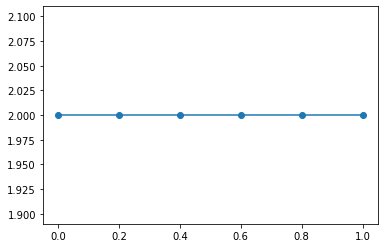

In [14]:
if len(E) < 10:
    plotmode = "o-"
else:
    plotmode = "-"
    
plt.plot(V, f(V), plotmode)

Solve and plot the solution.

In [15]:
u = sla.spsolve(A, b)

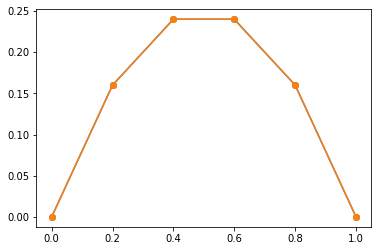

In [16]:
plt.plot(V, u, plotmode)

if uexact is not None:
    plt.plot(V, uexact(V), plotmode)

In [17]:
if uexact is not None:
    u_ex_h = uexact(V)
    print(la.norm(u - u_ex_h)/la.norm(u_ex_h))

9.622514525208466e-17
